# Bayesian Dynamic TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

## Dynamic TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{l \in L} \delta_l \mathbf{1}[t - k_i = l] + \epsilon_{it}
$$

### ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


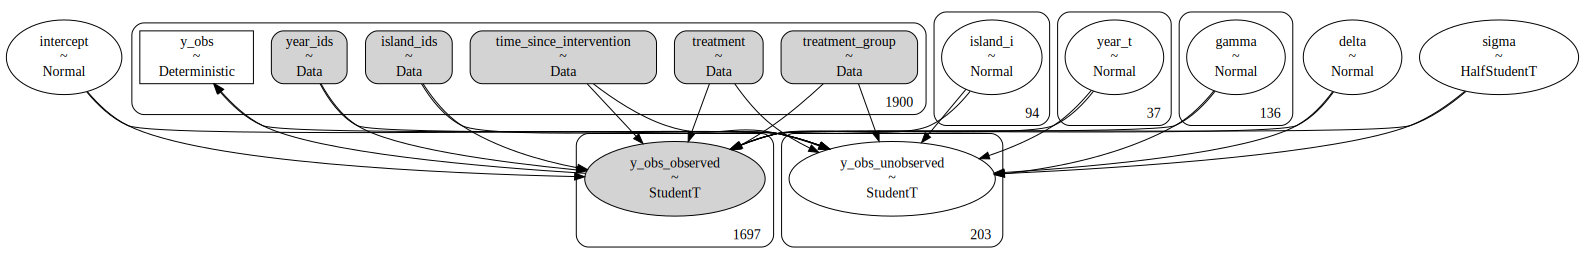

In [10]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'])
    year_ids = pm.Data('year_ids', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    # random effect
    island_i = pm.Normal('island_i', mu=0, sigma=100, shape=len(unique_island_ids))
    year_t = pm.Normal('year_t', mu=0, sigma=100, shape=len(unique_years))
    gamma = pm.Normal('gamma', mu=0, sigma=100, shape=len(df['time_since_intervention'].unique())) # 時間変動の介入効果

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100) # 時間固定の介入効果
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + island_i[island_ids] + year_t[year_ids] + delta * treatment + gamma[time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe)

In [11]:
with dynamic_twfe:
    trace_dynamic_twfe = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_dynamic_twfe)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [12]:
az.summary(trace_dynamic_twfe, var_names=['intercept', 'delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,326.834,24.959,279.765,376.020,1.801,1.281,193.0,260.0,1.01
delta,129.894,27.407,70.988,179.050,1.219,0.863,505.0,669.0,1.00
sigma,119.577,6.045,108.216,132.092,0.234,0.165,669.0,1011.0,1.00


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


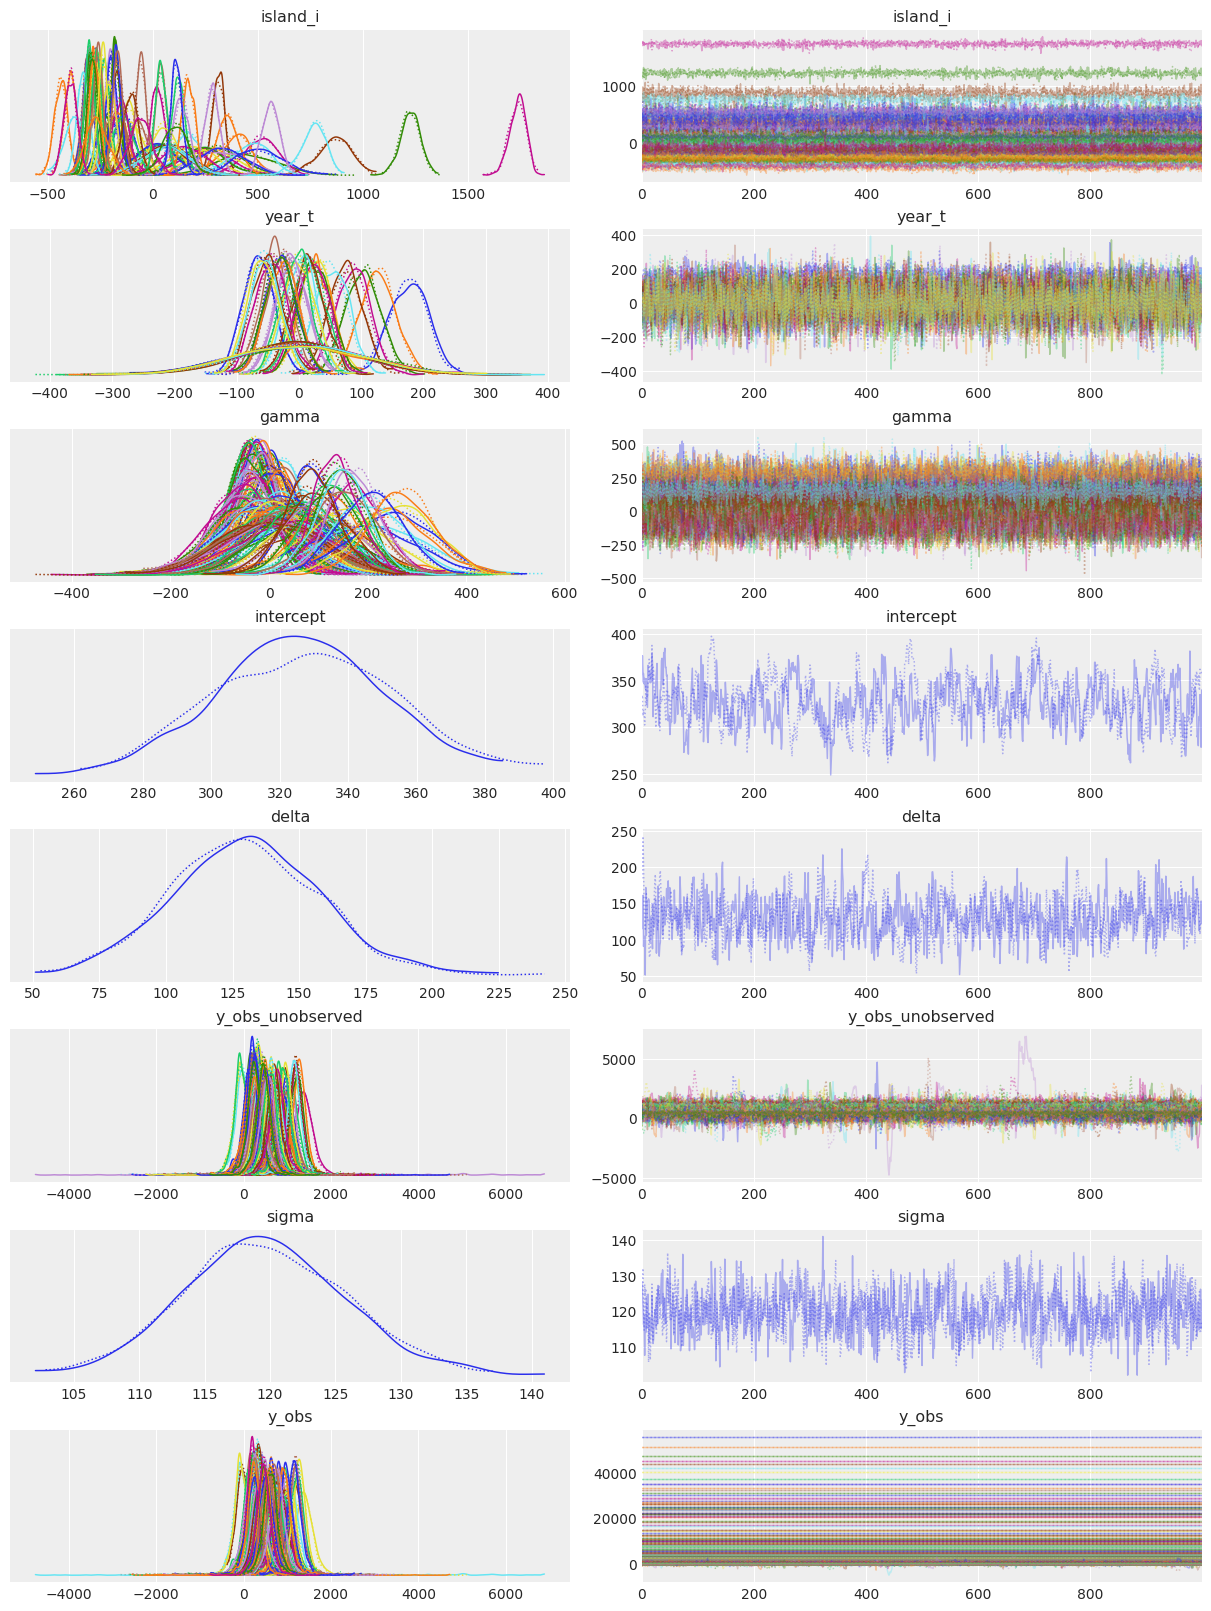

In [14]:
az.plot_trace(trace_dynamic_twfe);

In [13]:
az.waic(trace_dynamic_twfe)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13342.97   181.84
p_waic      129.93        -

There has been a warning during the calculation. Please check the results.

In [15]:
def get_delta_df(trace):
    # デルタのサマリーを取得
    delta_df = az.summary(trace, var_names=['delta'], hdi_prob=0.95, kind='stats')

    # 経過年数
    time_since_intervention_list = df['time_since_intervention'].unique()
    time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_intervention'])

    # デルタの値を経過年数と結合
    # デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
    delta_df.reset_index(drop=True, inplace=True)
    delta_df = pd.concat([delta_df, time_since_intervention_df], axis=1)

    return delta_df

def plot_effects_over_time(delta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_intervention',
        y='mean',
        data=delta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=delta_df['time_since_intervention'],
        y=delta_df['mean'],
        yerr=[
            delta_df['mean'] - delta_df['hdi_2.5%'],
            delta_df['hdi_97.5%'] - delta_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Effects Over Time')
    plt.legend()
    plt.show()

### 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


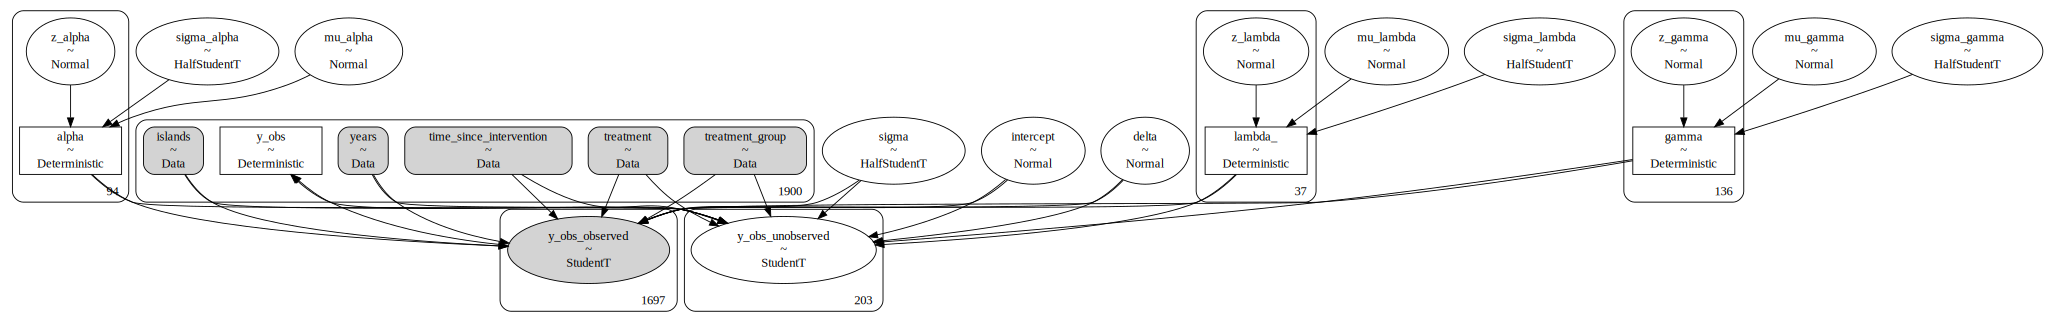

In [15]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

with pm.Model() as dynamic_twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])

    # priors
    # random effect
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfStudentT('sigma_alpha', nu=3, sigma=100)
    z_alpha = pm.Normal('z_alpha', mu=0, sigma=1, shape=len(df['island_ids'].unique()))
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * z_alpha)

    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfStudentT('sigma_lambda', nu=3, sigma=100)
    z_lambda = pm.Normal('z_lambda', mu=0, sigma=1, shape=len(df['years'].unique()))
    lambda_ = pm.Deterministic('lambda_', mu_lambda + sigma_lambda * z_lambda)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=100)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=100)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=len(df['time_since_intervention'].unique()))
    gamma = pm.Deterministic('gamma', mu_gamma + sigma_gamma * z_gamma)

    # fixed effect
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + delta * treatment + gamma[time_since_intervention]*treatment_group + alpha[islands] + lambda_[years]

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(dynamic_twfe_h)

In [ ]:
with dynamic_twfe_h:
    trace_dynamic_twfe_h = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
az.summary(trace_dynamic_twfe_h, var_names=['delta', 'sigma'], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta[0],17.800,42.459,-56.989,107.320,0.920,0.815,2130.0,1440.0,1.00
delta[1],-23.117,34.345,-88.617,46.483,0.779,0.619,1946.0,1482.0,1.00
delta[2],-39.326,32.138,-101.758,23.730,0.801,0.587,1625.0,1450.0,1.00
delta[3],-62.107,32.683,-126.564,2.045,0.761,0.596,1842.0,1500.0,1.00
delta[4],-54.834,40.516,-141.922,16.760,0.948,0.706,1833.0,1320.0,1.00
...,...,...,...,...,...,...,...,...,...
delta[132],52.467,34.924,-25.219,114.161,0.773,0.600,2016.0,1351.0,1.00
delta[133],30.310,29.841,-30.104,85.504,0.730,0.574,1675.0,1275.0,1.00
delta[134],-27.949,31.958,-94.619,30.006,0.741,0.581,1864.0,1538.0,1.00
delta[135],-11.961,33.711,-76.425,53.059,0.803,0.702,1798.0,1691.0,1.00


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


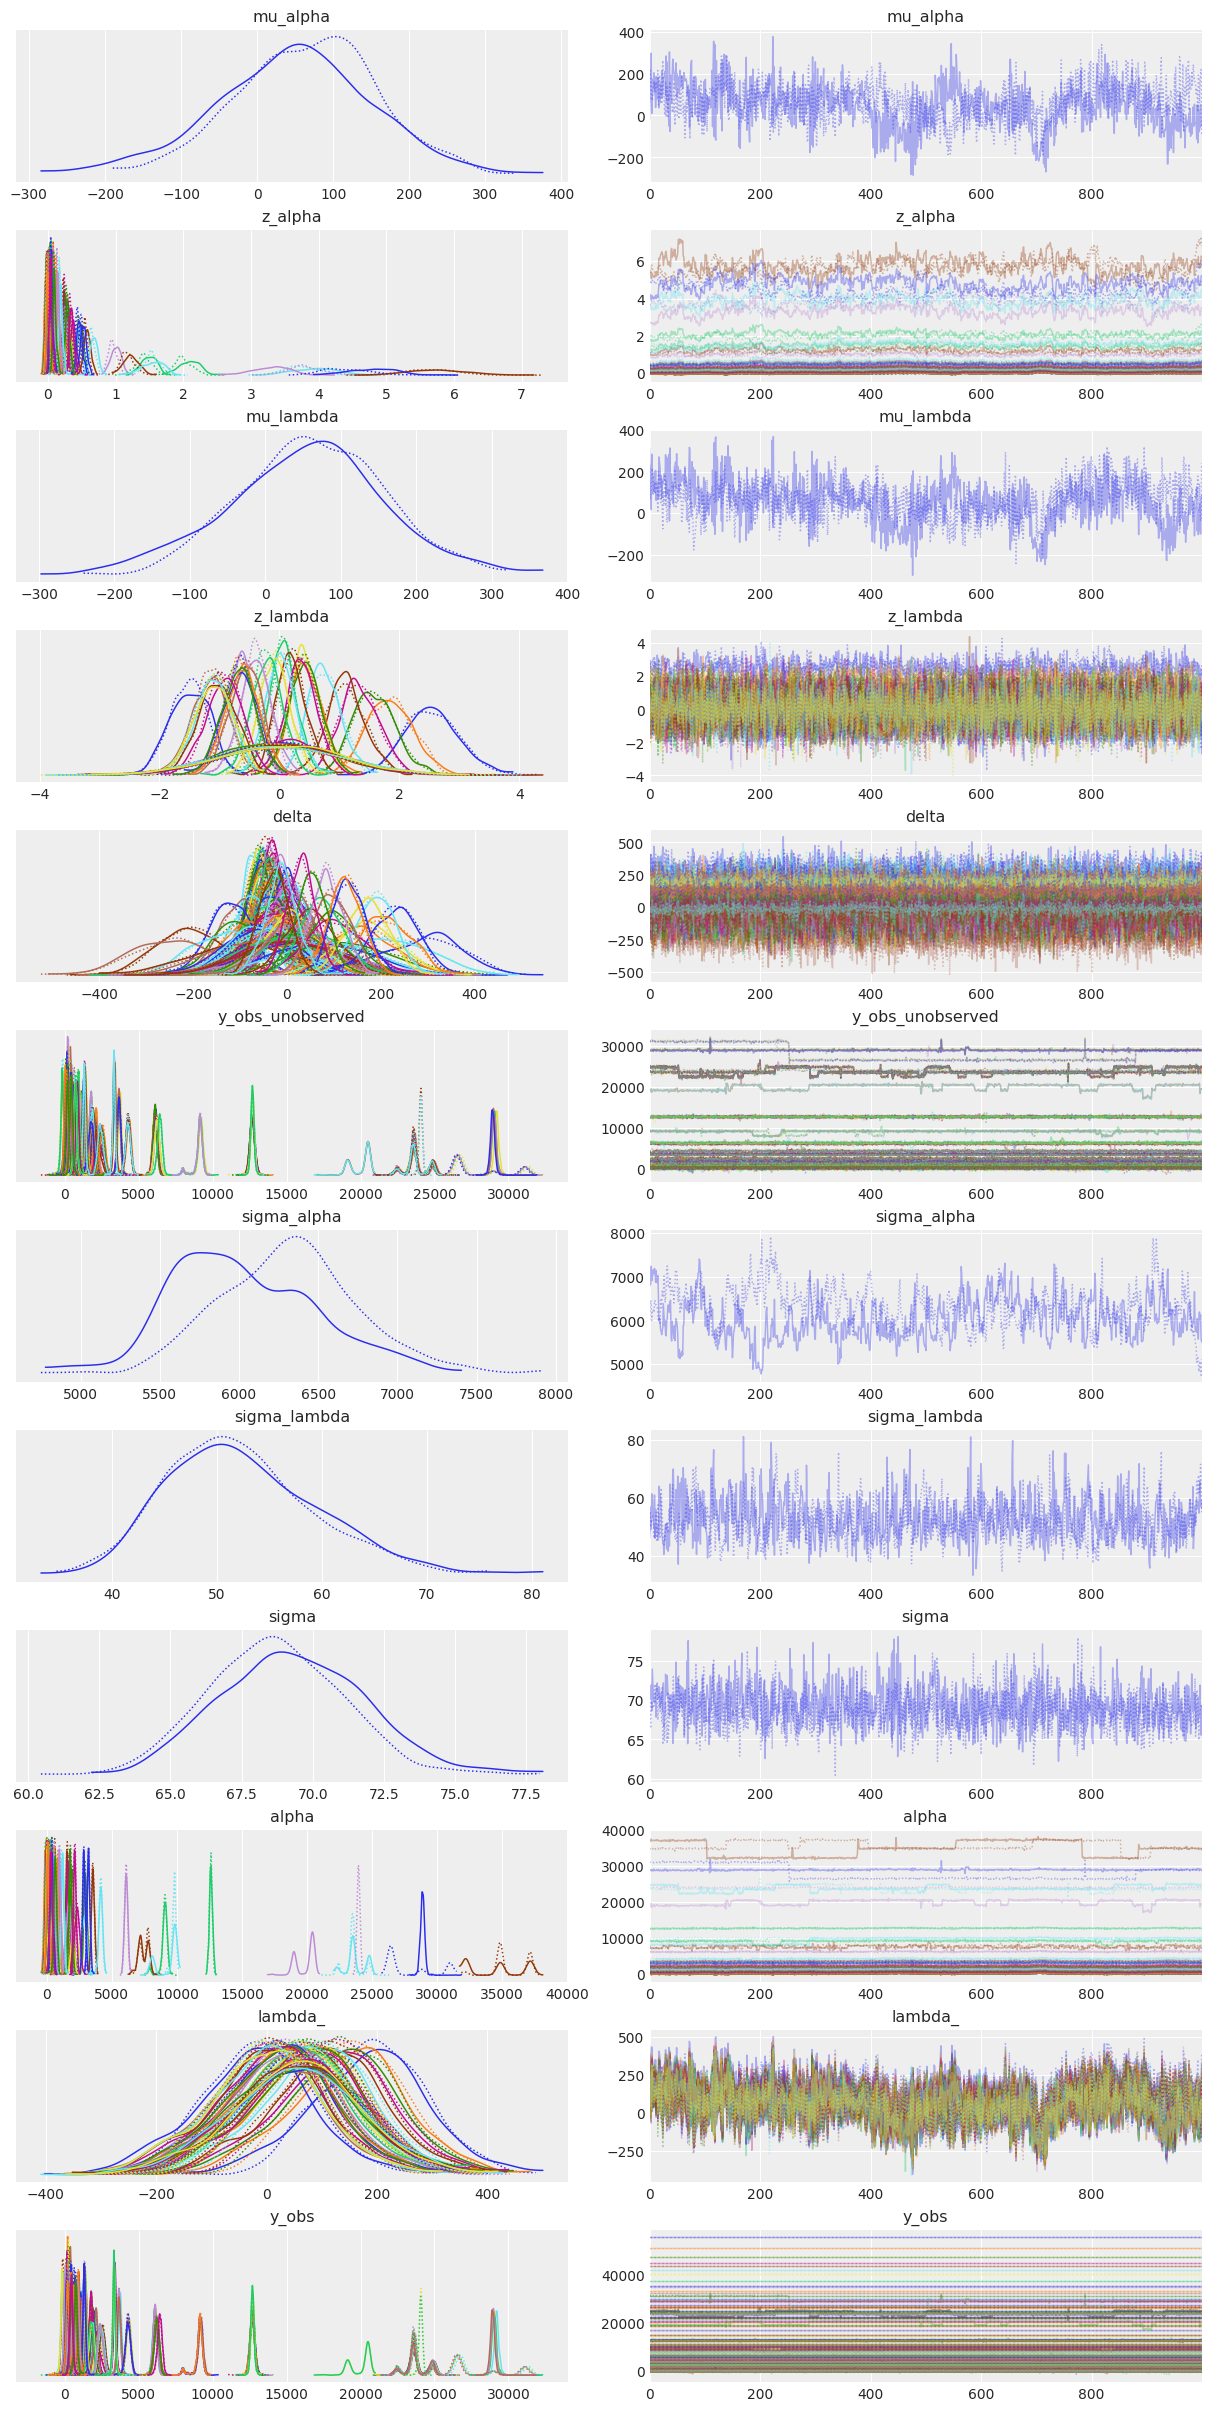

In [6]:
az.plot_trace(trace_dynamic_twfe_h);

In [7]:
with dynamic_twfe_h:
    pm.compute_log_likelihood(trace_dynamic_twfe_h)

az.loo(trace_dynamic_twfe_h)

Output()

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -11710.22   142.60
p_loo      560.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1688   99.5%
   (0.70, 1]   (bad)         4    0.2%
   (1, Inf)   (very bad)    5    0.3%

In [23]:
az.waic(trace_dynamic_twfe_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 2000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11948.83   175.69
p_waic      798.75        -

There has been a warning during the calculation. Please check the results.

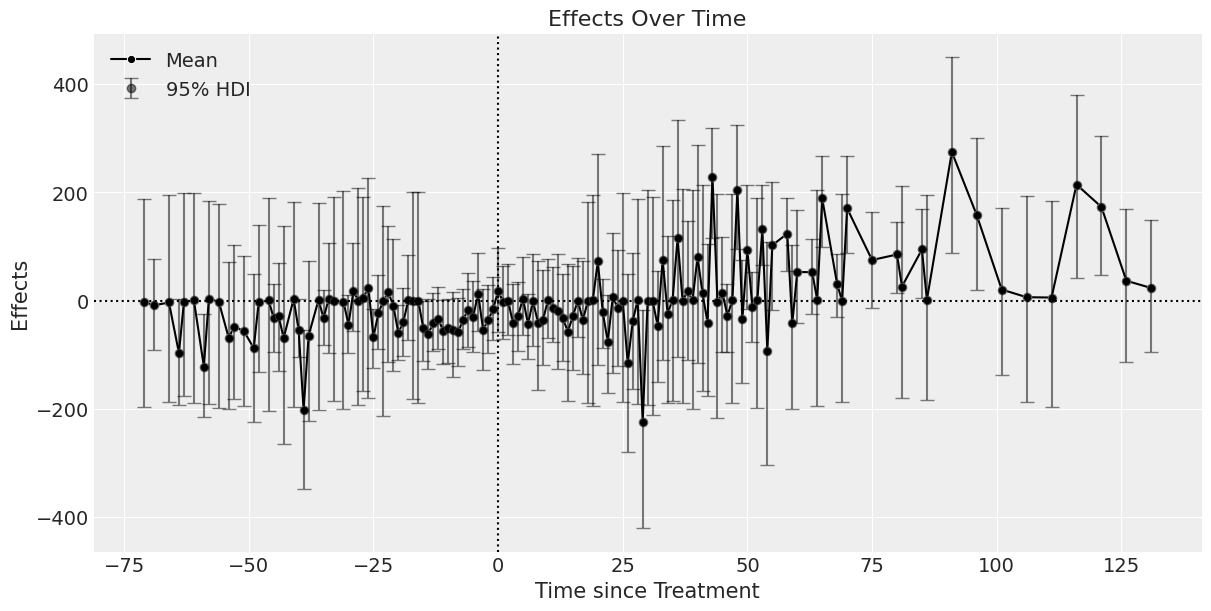

In [17]:
delta_df = get_delta_df(trace_dynamic_twfe_h)
plot_effects_over_time(delta_df)

## サンプリングの保存

In [24]:
az.to_netcdf(trace_dynamic_twfe, './sample/trace_dynamic_twfe.nc')
az.to_netcdf(trace_dynamic_twfe_h, './sample/trace_dynamic_twfe_h.nc')

'./sample/trace_dynamic_twfe_h.nc'